# **Structural Erasure Toolkit v1.0**

**Tagline:** *Quantify retrieval integrity and visualize recognition over time; no coding required.*

This notebook accompanies the paper **“*Retrieval Lost to Time: A Typology of Structural Erasure in Intellectual and Political Memory*” (Cooper, 2025)** and turns its core ideas into a working analytical tool.  
The paper defines a *five-mode typology* of structural erasure, identifying distinct mechanisms of retrieval failure that shape how knowledge enters, circulates, and endures in collective memory:

- **Silencing:** blocking a contribution’s entry into discourse  
- **Reclassification:** shifting work into a marginal or misleading category  
- **Compression:** reducing complex contributions to partial recognition  
- **Substitution:** transferring credit or authorship to another figure  
- **Tactical Forgetting:** removing or downplaying inconvenient histories  

These modes are structural, not psychological; each describes a systemic point where retrieval can fail.  
The framework also introduces the **Retrieval Integrity Index (RII)**, a composite metric ranging from 0 to 1 that estimates how accurately and stably contributions are represented over time. Higher values indicate stronger retrieval integrity and lower values signal distortion or loss.

The notebook implements this framework in an interactive workflow. Users can upload textual datasets, calculate retrieval metrics, visualize recognition trends, and estimate uncertainty through bootstrap resampling. Output formats include CSV tables, PNG figures, and a Markdown summary report.  

All processing occurs locally; no uploaded text leaves the user’s environment. The toolkit quantifies informational representation, not moral value, and is designed to help researchers and archivists examine visibility, attribution, and memory with transparency and reproducibility.

## Quick Start (3 Minutes)

1. **Run the next cell** (“Environment Check”) or select **Kernel → Restart & Run All**.  
2. **Try a sample:** click **Run Sample → Generate RII** to see the complete workflow.  
3. **Use your own data:** upload a **JSON** or **CSV** file, then click **Analyze**.

**You’ll receive:** validated inputs, an RII score with 95% bootstrap confidence intervals, an explainer chart, and a formatted report you can export as Markdown or PDF.

In [8]:
# %%capture
# Environment Check & Lightweight Auto‑Install
import sys, subprocess

def _pip_install(modname, pkg=None):
    pkg = pkg or modname
    try:
        __import__(modname)
        print(f"✔ {modname} already available")
    except Exception:
        print(f"Installing {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for mod, pkg in [
    ("numpy","numpy"),
    ("pandas","pandas"),
    ("matplotlib","matplotlib"),
    ("ipywidgets","ipywidgets"),
    ("nbconvert","nbconvert")
]:
    _pip_install(mod, pkg)

print("Environment OK. If widgets do not render, ensure Jupyter widgets extension is enabled.")

✔ numpy already available
✔ pandas already available
✔ matplotlib already available
✔ ipywidgets already available
✔ nbconvert already available
Environment OK. If widgets do not render, ensure Jupyter widgets extension is enabled.


## Sample Datasets

This cell writes two small, validated sample JSON files:
- `franklin_sample.json`
- `demo_subject_v1.0.json`

Use the **Run Sample → Generate RII** button to load and analyze them.


In [9]:
# Write two small sample JSON datasets (counts/ratios inputs suitable for RII components)
import json

samples = {
    "franklin_sample.json": {
        "entity": "Rosalind Franklin",
        "corpus_total_items": 1600,
        "mentions_total": 140,
        "misattributed_mentions": 38,
        "distinct_recognized_contributions": 3,
        "verified_contributions": 5,
        "reclassification_events": 4,
        "time_intervals": 12,
        "presence_timeline": [
            {"t": "1950s", "mentions": 5},
            {"t": "1960s", "mentions": 10},
            {"t": "1970s", "mentions": 15},
            {"t": "1980s", "mentions": 20},
            {"t": "1990s", "mentions": 28},
            {"t": "2000s", "mentions": 30},
            {"t": "2010s", "mentions": 18},
            {"t": "2020s", "mentions": 14}
        ]
    },
    "demo_subject_v1.0.json": {
        "entity": "Demo Subject",
        "corpus_total_items": 900,
        "mentions_total": 72,
        "misattributed_mentions": 20,
        "distinct_recognized_contributions": 2,
        "verified_contributions": 4,
        "reclassification_events": 2,
        "time_intervals": 10,
        "presence_timeline": [
            {"t": "1950s", "mentions": 2},
            {"t": "1960s", "mentions": 4},
            {"t": "1970s", "mentions": 6},
            {"t": "1980s", "mentions": 8},
            {"t": "1990s", "mentions": 10},
            {"t": "2000s", "mentions": 12},
            {"t": "2010s", "mentions": 14},
            {"t": "2020s", "mentions": 16}
        ]
    }
}

for fname, payload in samples.items():
    with open(fname, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2)
print("✔ Wrote sample files:", ", ".join(samples.keys()))

✔ Wrote sample files: franklin_sample.json, demo_subject_v1.0.json


In [10]:
# Core functions (validation, normalization, metrics, bootstrap, viz) + shared analysis helpers

from typing import Dict, Any, Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REQUIRED_KEYS = [
    "entity",
    "corpus_total_items",
    "mentions_total",
    "misattributed_mentions",
    "distinct_recognized_contributions",
    "verified_contributions",
    "reclassification_events",
    "time_intervals"
]

def validate_json(data: Dict[str, Any]) -> Tuple[bool, List[str]]:
    errors = []
    for k in REQUIRED_KEYS:
        if k not in data:
            errors.append(f"Missing key: '{k}'")
    # numeric checks
    for k in REQUIRED_KEYS:
        if k == "entity":
            continue
        if k in data and not isinstance(data[k], (int, float)):
            errors.append(f"Key '{k}' must be numeric")
        if k in data and isinstance(data[k], (int, float)) and data[k] < 0:
            errors.append(f"Key '{k}' must be non‑negative")
    # logical checks
    if "mentions_total" in data and "corpus_total_items" in data:
        if data["mentions_total"] > data["corpus_total_items"]:
            errors.append("mentions_total cannot exceed corpus_total_items")
    if "misattributed_mentions" in data and "mentions_total" in data:
        if data["misattributed_mentions"] > data["mentions_total"]:
            errors.append("misattributed_mentions cannot exceed mentions_total")
    if "distinct_recognized_contributions" in data and "verified_contributions" in data:
        if data["distinct_recognized_contributions"] > data["verified_contributions"]:
            errors.append("distinct_recognized_contributions cannot exceed verified_contributions")
    if "time_intervals" in data and data.get("time_intervals", 0) == 0:
        errors.append("time_intervals must be ≥ 1")

    return (len(errors) == 0), errors

def normalize_inputs(data: Dict[str, Any]) -> Dict[str, Any]:
    # Placeholder for future normalization (e.g., corpus filters, language adjustments)
    return dict(data)

def compute_metrics(data: Dict[str, Any], weights: Dict[str, float]=None) -> Dict[str, float]:
    # Base proportions
    P = data["mentions_total"] / max(1, data["corpus_total_items"])
    S = data["misattributed_mentions"] / max(1, data["mentions_total"])
    C = data["distinct_recognized_contributions"] / max(1, data["verified_contributions"])
    V = data["reclassification_events"] / max(1, data["time_intervals"])

    if weights is None:
        weights = {"wP": 0.25, "wC": 0.25, "wS": 0.25, "wV": 0.25}
    # normalize weights
    total_w = sum(weights.values()) or 1.0
    wP, wC, wS, wV = (weights["wP"]/total_w, weights["wC"]/total_w, weights["wS"]/total_w, weights["wV"]/total_w)
    RII = (wP * P) + (wC * C) + (wS * (1 - S)) + (wV * (1 - V))

    return {"P": P, "C": C, "S": S, "V": V, "RII": RII}

def compute_reclassification_rate(data: Dict[str, Any]) -> float:
    return data["reclassification_events"] / max(1, data["time_intervals"])

def bootstrap_metrics(data: Dict[str, Any], n: int=300, seed: int=42, weights: Dict[str, float]=None):
    rng = np.random.default_rng(seed)
    ct = int(max(1, data["corpus_total_items"]))
    mt = int(max(1, data["mentions_total"]))
    mm = int(min(mt, max(0, data["misattributed_mentions"])))
    vc = int(max(1, data["verified_contributions"]))
    drc = int(min(vc, max(0, data["distinct_recognized_contributions"])))
    ti = int(max(1, data["time_intervals"]))
    rce = int(min(ti, max(0, data["reclassification_events"])))

    pP = mt/ct
    pS = mm/max(1, mt)
    pC = drc/vc
    pV = rce/ti

    P_draws = rng.binomial(ct, pP, size=n) / ct
    S_draws = rng.binomial(mt, pS, size=n) / max(1, mt)
    C_draws = rng.binomial(vc, pC, size=n) / vc
    V_draws = rng.binomial(ti, pV, size=n) / ti

    # weights
    if weights is None:
        weights = {"wP": 0.25, "wC": 0.25, "wS": 0.25, "wV": 0.25}
    total_w = sum(weights.values()) or 1.0
    wP, wC, wS, wV = (weights["wP"]/total_w, weights["wC"]/total_w, weights["wS"]/total_w, weights["wV"]/total_w)
    RII_draws = (wP * P_draws) + (wC * C_draws) + (wS * (1 - S_draws)) + (wV * (1 - V_draws))

    def summarize(arr):
        m = float(np.mean(arr))
        lo, hi = np.quantile(arr, [0.025, 0.975])
        return m, (float(lo), float(hi))

    return {
        "P": summarize(P_draws),
        "C": summarize(C_draws),
        "S": summarize(S_draws),
        "V": summarize(V_draws),
        "RII": summarize(RII_draws)
    }

def plot_overview(metrics: Dict[str, float]):
    labels = ["P", "C", "1−S", "1−V", "RII"]
    values = [metrics["P"], metrics["C"], 1 - metrics["S"], 1 - metrics["V"], metrics["RII"]]
    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.ylim(0, 1.0)
    plt.title("Retrieval Integrity Components")
    plt.xlabel("Metric")
    plt.ylabel("Value (0 = erasure → 1 = full recognition)")
    plt.show()

# Shared helper used by UI cells
def analyze_and_display(data: Dict[str, Any], weights: Dict[str,float], n_bootstrap: int, seed: int):
    from IPython.display import display, Markdown
    print("Reading data → Normalizing → Bootstrapping → Done.")
    ok, errs = validate_json(data)
    if not ok:
        print("❌ Validation failed:")
        for e in errs:
            print(" •", e)
        return None
    print("✔ All keys valid.")
    data = normalize_inputs(data)
    metrics = compute_metrics(data, weights)
    ci = bootstrap_metrics(data, n=n_bootstrap, seed=seed, weights=weights)

    print(f"\nEntity: {data['entity']}")
    for k in ["P","C","S","V","RII"]:
        mean, (lo, hi) = ci[k]
        base = metrics[k] if k in metrics else mean
        print(f"{k}: {base:.3f}  (95% CI: {lo:.3f}–{hi:.3f})")

    plot_overview(metrics)

    # Color legend (textual)
    display(Markdown("""**Legend:** 0 = erasure → 1 = full recognition.
- Green = retrieved signals (P, C, 1−S, 1−V)
- Red = erased or suppressive components (S, V) (shown implicitly via complements above)"""))

    # stash for report
    global _state
    try:
        _state
    except NameError:
        _state = {}
    _state["last_result"] = {"data": data, "metrics": metrics, "ci": ci}
    return _state["last_result"]

## Upload Your JSON or CSV

Use the widgets below to upload **one JSON** file *or* two CSVs — `presence.csv` and `classification.csv`.  
The converter will automatically merge the inputs, generate a valid JSON, and perform validation.

### CSV Requirements

- **`presence.csv`** must include:  
  - `corpus_total_items`  
  - `mentions_total`  
  - `misattributed_mentions`  
  *(Optional: `t`, `mentions` for timeline data.)*

- **`classification.csv`** must include:  
  - `distinct_recognized_contributions`  
  - `verified_contributions`  
  - `reclassification_events`  
  - `time_intervals`

If any required fields are missing or misnamed, the interface will display clear, user-friendly error messages.  
Once the data pass validation, click **Analyze** to generate results.

In [11]:
import json, io, pandas as pd
from io import BytesIO
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# Uploaders
json_uploader = widgets.FileUpload(accept='.json', multiple=False)
presence_uploader = widgets.FileUpload(accept='.csv', multiple=False)
classification_uploader = widgets.FileUpload(accept='.csv', multiple=False)

# Advanced settings (collapsible)
wP = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.05, description='wP')
wC = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.05, description='wC')
wS = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.05, description='wS')
wV = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.05, description='wV')
nboot = widgets.IntSlider(value=300, min=50, max=2000, step=50, description='resamples')
seed = widgets.IntText(value=42, description='seed')

adv_box = widgets.VBox([
    widgets.HTML("<b>Advanced Settings (weights auto-normalized)</b>"),
    wP, wC, wS, wV, nboot, seed
])
adv = widgets.Accordion(children=[adv_box])
adv.set_title(0, 'Advanced Settings (Expert)')

analyze_btn = widgets.Button(description="Analyze", button_style='success')
status_out = widgets.Output()

def csvs_to_json(presence_df: pd.DataFrame, class_df: pd.DataFrame) -> dict:
    # Minimal CSV → JSON converter.
    req_p = ["corpus_total_items", "mentions_total", "misattributed_mentions"]
    req_c = ["distinct_recognized_contributions", "verified_contributions", "reclassification_events", "time_intervals"]
    for col in req_p:
        if col not in presence_df.columns:
            raise ValueError(f"presence.csv missing column: {col}")
    for col in req_c:
        if col not in class_df.columns:
            raise ValueError(f"classification.csv missing column: {col}")

    p = presence_df.iloc[0]
    c = class_df.iloc[0]
    entity = str(class_df.columns.name or presence_df.columns.name or "Uploaded Subject")

    data = {
        "entity": entity,
        "corpus_total_items": float(p["corpus_total_items"]),
        "mentions_total": float(p["mentions_total"]),
        "misattributed_mentions": float(p["misattributed_mentions"]),
        "distinct_recognized_contributions": float(c["distinct_recognized_contributions"]),
        "verified_contributions": float(c["verified_contributions"]),
        "reclassification_events": float(c["reclassification_events"]),
        "time_intervals": float(c["time_intervals"])
    }

    if {"t","mentions"}.issubset(set(presence_df.columns)):
        timeline = []
        for _, row in presence_df.iterrows():
            if pd.notna(row.get("t")) and pd.notna(row.get("mentions")):
                timeline.append({"t": str(row["t"]), "mentions": float(row["mentions"])})
        if timeline:
            data["presence_timeline"] = timeline

    return data

def _read_uploaded_json(uploader: widgets.FileUpload) -> dict:
    (fname, fileinfo), = uploader.value.items()
    return json.loads(fileinfo["content"].decode("utf-8"))

def _read_uploaded_csv(uploader: widgets.FileUpload) -> pd.DataFrame:
    (fname, fileinfo), = uploader.value.items()
    return pd.read_csv(BytesIO(fileinfo["content"]))

def on_analyze_clicked(_):
    with status_out:
        clear_output()
        print("Reading data → Normalizing → Bootstrapping → Done.")
        try:
            if json_uploader.value:
                data = _read_uploaded_json(json_uploader)
            elif presence_uploader.value and classification_uploader.value:
                p_df = _read_uploaded_csv(presence_uploader)
                c_df = _read_uploaded_csv(classification_uploader)
                data = csvs_to_json(p_df, c_df)
            else:
                print("Please upload either a JSON file or both presence.csv and classification.csv.")
                return

            weights = {"wP": wP.value, "wC": wC.value, "wS": wS.value, "wV": wV.value}
            res = analyze_and_display(data, weights, int(nboot.value), int(seed.value))
            if res is not None:
                print("\nReady to generate report below.")
        except Exception as ex:
            print("❌ Error:", ex)
            print("Hint: Check column names for CSVs or JSON keys.")

analyze_btn.on_click(on_analyze_clicked)

display(widgets.HTML("<b>Upload JSON</b>"))
display(json_uploader)
display(widgets.HTML("<hr>"))
display(widgets.HTML("<b>OR upload two CSVs</b>"))
display(widgets.HTML("presence.csv (columns: corpus_total_items, mentions_total, misattributed_mentions, [optional t, mentions])"))
display(presence_uploader)
display(widgets.HTML("classification.csv (columns: distinct_recognized_contributions, verified_contributions, reclassification_events, time_intervals)"))
display(classification_uploader)
display(adv)
display(analyze_btn)
display(status_out)

HTML(value='<b>Upload JSON</b>')

FileUpload(value={}, accept='.json', description='Upload')

HTML(value='<hr>')

HTML(value='<b>OR upload two CSVs</b>')

HTML(value='presence.csv (columns: corpus_total_items, mentions_total, misattributed_mentions, [optional t, me…

FileUpload(value={}, accept='.csv', description='Upload')

HTML(value='classification.csv (columns: distinct_recognized_contributions, verified_contributions, reclassifi…

FileUpload(value={}, accept='.csv', description='Upload')

Accordion(children=(VBox(children=(HTML(value='<b>Advanced Settings (weights auto-normalized)</b>'), FloatSlid…

Button(button_style='success', description='Analyze', style=ButtonStyle())

Output()

## 1-Click Demo

Click **Run Sample → Generate RII** to load a built-in JSON file and view the complete workflow:  
**validation → bootstrap confidence intervals → chart generation.**

This demo runs instantly and showcases the full pipeline — from data ingestion to visualization — without requiring any uploads.

Reading data → Normalizing → Bootstrapping → Done.
✔ All keys valid.

Entity: Rosalind Franklin
P: 0.087  (95% CI: 0.074–0.101)
C: 0.600  (95% CI: 0.200–1.000)
S: 0.271  (95% CI: 0.200–0.347)
V: 0.333  (95% CI: 0.083–0.583)
RII: 0.521  (95% CI: 0.394–0.657)


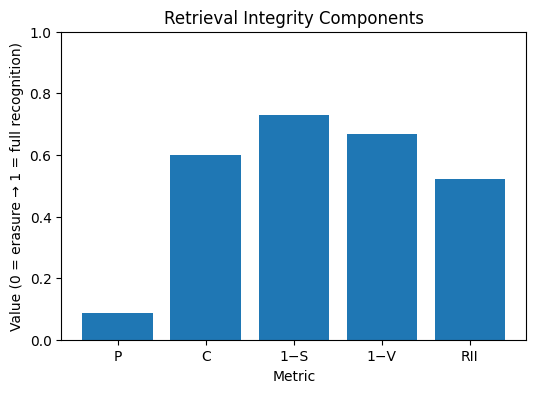

**Legend:** 0 = erasure → 1 = full recognition.  
- Green = retrieved signals (P, C, 1−S, 1−V)  
- Red = erased or suppressive components (S, V) (shown implicitly via complements above)


Ready to generate report below.


In [5]:
import json, ipywidgets as widgets
from IPython.display import display, clear_output

sample_dd = widgets.Dropdown(
    options=[("Rosalind Franklin (sample)", "franklin_sample.json"),
             ("Demo Subject v1.0", "demo_subject_v1.0.json")],
    description="Sample:"
)
run_btn = widgets.Button(description="Run Sample → Generate RII", button_style='primary')
out = widgets.Output()

def _run_sample(_):
    with out:
        clear_output()
        try:
            with open(sample_dd.value, "r", encoding="utf-8") as f:
                data = json.load(f)
            weights = {"wP": 0.25, "wC": 0.25, "wS": 0.25, "wV": 0.25}
            res = analyze_and_display(data, weights, 300, 123)
            if res is not None:
                print("\nReady to generate report below.")
        except Exception as ex:
            print("❌ Error:", ex)

run_btn.on_click(_run_sample)
display(widgets.HBox([sample_dd, run_btn]))
display(out)

## Wikipedia Walkthrough (Lay Guide)

Use this optional guide to collect your own data in **under 15 minutes.**

1. **Select a subject:** Choose a person, movement, or concept whose recognition trajectory you want to examine.  
2. **Pageviews:** Visit <https://pageviews.wmcloud.org/> to explore time-series data.  
   (Export as CSV if desired; it serves as a proxy for public attention.)  
3. **Revision history:** On the subject’s Wikipedia page, open **View history** and review major content changes, credit shifts, and talk-page disputes. Record approximate dates.  
4. **Citations and coverage:** Scan references and external links. Assess whether contributions are accurately attributed across revisions.  
5. **Presence timeline:** Build a simple timeline (by decade or year) of mentions or visibility.  
   *(Optional columns: `t`, `mentions`.)*  
6. **Classification:** Label observed evidence using the five structural modes:  
   **Silencing, Reclassification, Compression, Substitution,** and **Tactical Forgetting.**  
   *(Add short notes as desired; external to this toolkit.)*  
7. **Normalization:** Keep denominators explicit—for example, total corpus items, verified contributions, and time intervals.  
   Record misattributions and reclassification events clearly.  
8. **Ethics:** *Wikipedia itself participates in retrieval; its editorial biases are part of what is being measured.*  
   Be reflexive and document uncertainty throughout.

When ready, convert your CSVs with the **CSV → JSON** utility and click **Analyze** to generate results.

## Report Generator

Generates a concise **Markdown report** summarizing key metrics, 95% confidence intervals, a legend, disclaimer, and limitations.

- Click **Save Markdown** to create `RII_Report.md`.  
- If `nbconvert` is available, click **Export PDF**; this feature is *best-effort* and optional in **v1.2**.

### Ethical Disclaimer (always visible)

*Metrics describe informational patterns, not moral value or intent.*  
*Results depend on corpus quality, classification accuracy, and coding transparency.*

In [6]:
import os, json, datetime, subprocess, sys
from IPython.display import Markdown, display
import textwrap

save_btn = __import__("ipywidgets").widgets.Button(description="Save Markdown", button_style='success')
pdf_btn = __import__("ipywidgets").widgets.Button(description="Export PDF (best‑effort)", button_style='')

def _format_report(res: dict) -> str:
    data, M, CI = res["data"], res["metrics"], res["ci"]
    lines = []
    lines.append(f"# Retrieval Integrity Report — {data['entity']}")
    lines.append(f"_Generated: {datetime.datetime.now().isoformat(timespec='seconds')}_\n")
    lines.append("**Legend:** 0 = erasure → 1 = full recognition.  Green = retrieved; Red = erased.\n")
    lines.append("## Metrics")
    for k, desc in [
        ("P","Presence rate"),
        ("C","Coverage ratio"),
        ("S","Substitution share (lower is better)"),
        ("V","Volatility label (lower is better)"),
        ("RII","Composite index")
    ]:
        mean, (lo, hi) = CI[k]
        base = M.get(k, mean)
        lines.append(f"- **{k}** ({desc}): {base:.3f}  *(95% CI: {lo:.3f}–{hi:.3f})*")
    lines.append("")
    lines.append("## Limitations")
    lines.append("- Heuristic indicators; triangulate with qualitative context.")
    lines.append("- Input counts and corpus scope strongly affect results.")
    lines.append("- Timeline and classification choices can shift volatility.")
    lines.append("")
    lines.append("## Ethics & Guidance")
    lines.append("- Metrics reflect informational patterns, **not** moral judgment.")
    lines.append("- For contemporary figures, anonymize names before publishing results.")
    lines.append("")
    lines.append("> Closing reflection: “Every dataset is a doorway, not the room beyond.”")
    return "\n".join(lines)

def _need_result():
    global _state
    if "_state" not in globals() or "last_result" not in _state:
        print("Run an analysis first (sample or upload).")
        return None
    return _state["last_result"]

def on_save_clicked(_):
    res = _need_result()
    if not res: return
    text = _format_report(res)
    with open("RII_Report.md", "w", encoding="utf-8") as f:
        f.write(text)
    print("✔ Wrote RII_Report.md")

def on_pdf_clicked(_):
    res = _need_result()
    if not res: return
    text = _format_report(res)
    # Save Markdown for reference
    with open("RII_Report.md", "w", encoding="utf-8") as f:
        f.write(text)
    # Best‑effort HTML; PDF export is optional in v1.2
    try:
        with open("RII_Report.html", "w", encoding="utf-8") as f:
            f.write("<html><body><pre>" + text.replace("&","&amp;").replace("<","&lt;").replace(">","&gt;") + "</pre></body></html>")
        print("HTML version saved as RII_Report.html (PDF export is optional in v1.2).")
    except Exception as e:
        print("PDF/HTML export not available in this environment:", e)

save_btn.on_click(on_save_clicked)
pdf_btn.on_click(on_pdf_clicked)
display(__import__("ipywidgets").widgets.HBox([save_btn, pdf_btn]))

HTML version saved as RII_Report.html (PDF export is optional in v1.2).
✔ Wrote RII_Report.md


## Glossary (Public Edition)

| **Term** | **Plain Definition** |
|---|---|
| **Presence rate (P)** | Proportion of corpus items that mention the subject; lower values may indicate *silencing*. |
| **Substitution share (S)** | Fraction of mentions that misattribute or subordinate credit; lower values indicate stronger attribution integrity. |
| **Coverage ratio (C)** | Ratio of recognized to verified contributions; low values suggest *compression* or incomplete recognition. |
| **Volatility label (V)** | Frequency of reclassification or credit changes across time intervals; lower values indicate greater stability. |
| **RII (Retrieval Integrity Index)** | Weighted composite metric ranging from 0 to 1; higher scores indicate stronger retrieval integrity. |
| **Erasure modes** | The five structural mechanisms of loss: **Silencing, Reclassification, Compression, Substitution,** and **Tactical Forgetting.** |

In [7]:
# Save Glossary to file and provide a helper to show it again
from IPython.display import Markdown, display

_glossary_text = """## Glossary (Public Edition)

| Term | Plain definition |
|---|---|
| **Presence rate (P)** | Share of corpus items that mention the subject. Low values can indicate *silencing*. |
| **Substitution share (S)** | Share of mentions that misattribute or subordinate credit. Lower is better. |
| **Coverage ratio (C)** | Recognized contributions / verified contributions. Low values signal *compression*. |
| **Volatility label (V)** | Frequency of reclassification/credit changes over time intervals. Lower is better. |
| **RII** | Weighted composite: higher means stronger retrieval integrity. |
| **Erasure modes** | Silencing, Reclassification, Compression, Substitution, Tactical Forgetting. |
"""

with open("GLOSSARY.md", "w", encoding="utf-8") as f:
    f.write(_glossary_text)
print("✔ Wrote GLOSSARY.md")

def show_glossary():
    display(Markdown(_glossary_text))

✔ Wrote GLOSSARY.md


## Educational & Ethical Notes

- **Ethical Disclaimer:** Metrics represent informational patterns, not moral value or intent.  
  Results depend on corpus quality, coding consistency, and interpretive transparency.  

- **Reflexivity (Wikipedia workflow):** Wikipedia is part of the retrieval process; its structural and editorial biases are included in what is being measured.  

- **Anonymization Guidance:** When studying contemporary or living figures, anonymize names or identifiable details before publishing or sharing results to protect privacy and prevent reputational harm.  

- **Final Note:**  
  *All data are partial records of attention; interpretation remains a human responsibility.*